# Next day "close" predictor

In this paper, I will train a model that will predict the next day's closing price of a security.
This price prediction will be transferred to the decision block based on risk and financial management.

As data we will take a dataset from kaggle: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from typing import List
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.metrics import mean_absolute_error

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

import lightgbm as lgb

Take The Procter & Gamble (NYSE ticker: PG) as an example

## 1. EDA

In [3]:
# read the data
df = pd.read_csv("pg.us.txt", parse_dates=["Date"])

In [4]:
df.shape

(12075, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12075 non-null  datetime64[ns]
 1   Open     12075 non-null  float64       
 2   High     12075 non-null  float64       
 3   Low      12075 non-null  float64       
 4   Close    12075 non-null  float64       
 5   Volume   12075 non-null  int64         
 6   OpenInt  12075 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 660.5 KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


In [7]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
12070,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0
12071,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0
12072,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0
12073,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0
12074,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0


In [8]:
df["OpenInt"].describe()

count    12075.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: OpenInt, dtype: float64

In [9]:
# check min max Date
df["Date"].min(), df["Date"].max()

(Timestamp('1970-01-02 00:00:00'), Timestamp('2017-11-10 00:00:00'))

<AxesSubplot:xlabel='Date'>

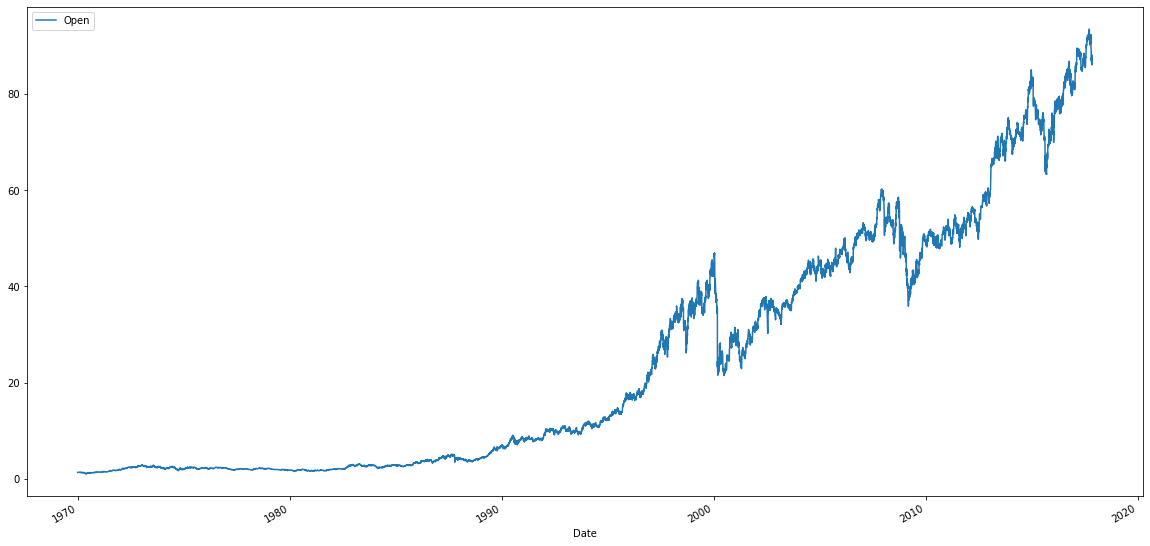

In [10]:
# Let's take a look at the opening chart.
df.plot(x="Date", y="Open",figsize=(20,10))

Our dataset has information about open/close prices, minimum/maximum, and traded volume. The column of Open Interest is empty. Let's try to use this simple dataset at the beginning. Later on, we will get additional data from the trading terminal using API.

Based on the available chart we can say that this paper is interesting for financiers and investors. We can see that the Paper periodically rewrites its historical highs. It never reaches historically-significant minimums during crises (before 2000 and 2008), and so it is held in times of crisis, and during "good times" it attracts investors.

Based on the graph, we can say that we have a certain trend in the company as a whole. It is determined by inflation, company development, and capital injections. So we will use a time series approach in our solution. In this notebook we will try LightGBM. And in another notebook I will try to train a neural network.

In [11]:
# check correlation
df[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999907,0.999920,0.999947
Close,0.999907,1.000000,0.999926,0.999953
Low,0.999920,0.999926,1.000000,0.999889
High,0.999947,0.999953,0.999889,1.000000


From the "head" and "tail" analysis, we can see that the volumes in 1970 and 2017 differ by a factor of about 10. Therefore, for training we take only the actual data for the last few years. However, it is important that the sample includes the recession period. From the graph, we can see that if we take 7 years, the recession will be in the sample.

In [12]:
df_7 = df[df["Date"] > df["Date"].max() - timedelta(days=365 * 7.2)]

In [13]:
df_7.shape

(1813, 7)

In [14]:
# checking
df_7["Date"].min(), df_7["Date"].max()

(Timestamp('2010-09-01 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [15]:
df_7.head(15)

,Date,Open,High,Low,Close,Volume,OpenInt
10262,2010-09-01,48.303,48.447,48.026,48.243,18281466,0
10263,2010-09-02,48.197,48.647,48.173,48.462,12714548,0
10264,2010-09-03,48.682,48.810,48.266,48.639,11118652,0
10265,2010-09-07,48.414,48.769,48.341,48.518,9197970,0
10266,2010-09-08,48.526,48.810,48.526,48.705,9568414,0
10267,2010-09-09,48.946,48.961,48.577,48.639,9838673,0
10268,2010-09-10,48.817,48.915,48.631,48.727,9145890,0
10269,2010-09-13,48.931,49.003,48.583,48.794,12154837,0
10270,2010-09-14,48.719,49.164,48.664,48.924,13648677,0
10271,2010-09-15,48.856,49.543,48.832,49.300,11384616,0


In [16]:
# Use the datetime column as an index
df_7=df_7.set_index(['Date'])

# Let's sort the data
df_7.sort_index(inplace=True)

# Let's check
df_7.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-09-01,48.303,48.447,48.026,48.243,18281466,0
2010-09-02,48.197,48.647,48.173,48.462,12714548,0
2010-09-03,48.682,48.810,48.266,48.639,11118652,0
2010-09-07,48.414,48.769,48.341,48.518,9197970,0
2010-09-08,48.526,48.810,48.526,48.705,9568414,0


In [17]:
searcher = df_7.copy()

In [18]:
searcher = searcher[["Close"]]

In [19]:
searcher

,Close
Date,
2010-09-01,48.243
2010-09-02,48.462
2010-09-03,48.639
2010-09-07,48.518
2010-09-08,48.705
...,...
2017-11-06,86.050
2017-11-07,86.980
2017-11-08,87.580


<AxesSubplot:xlabel='Date'>

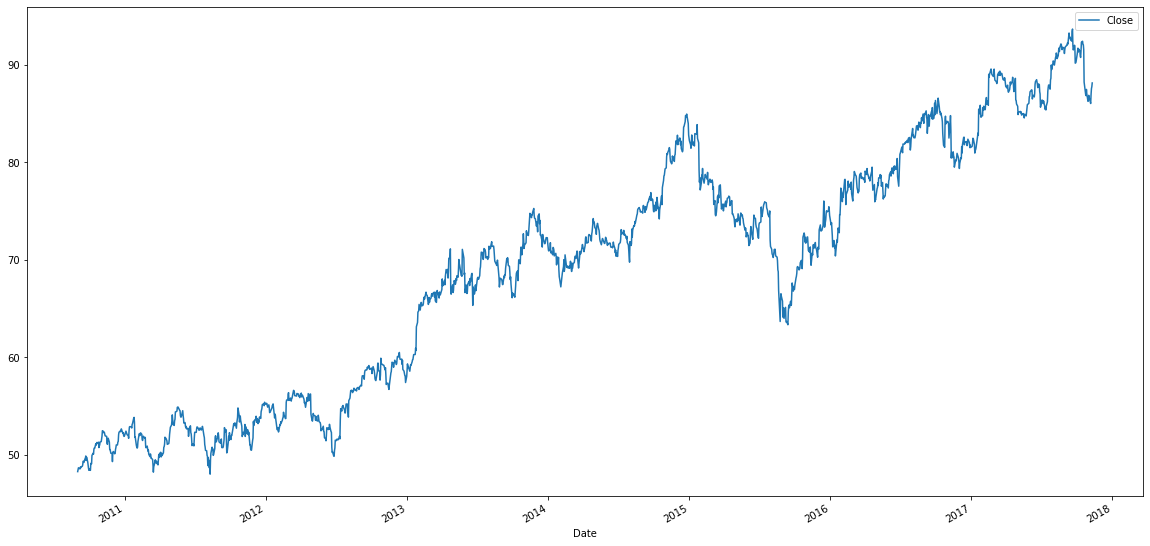

In [20]:
# Let's take a look at our time series
searcher.plot(figsize=(20,10))

## 2. Инжиниринг

In [21]:
def make_features(df, max_lag, rolling_mean_size):
    '''
    input:
    
        df - DataFrameObject - dataframe
    
        max_lag - int - the number of lags (features) to be added with an offset of 1 step
            
        rollling_mean_size - int - number of intervals for averaging
    
    This function generates additional features based on time series math.
    It adds day of the week, lag offsets, and moving averages.
    
    '''
    
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['Close'].shift(lag)

    df['rolling_mean'] = df['Close'].shift().rolling(rolling_mean_size).mean()
    
    print('Строка документации: \n', make_features.__doc__)   

In [22]:
# Make features
make_features(df_7, 2, 23)
df_7=df_7.dropna()

Строка документации: 
 
    input:
    
        df - DataFrameObject - dataframe
    
        max_lag - int - the number of lags (features) to be added with an offset of 1 step
            
        rollling_mean_size - int - number of intervals for averaging
    
    This function generates additional features based on time series math.
    It adds day of the week, lag offsets, and moving averages.
    
    


So, we need to create a custom dataset. We need to predict the closing price and continue to generate the features.

1) We will use the opening and closing prices of the previous days as features.

2) There are gaps in the stock market. We will calculate them by subtracting the previous day closing price from the opening price of the current day.

3) We will leave the volume unchanged (in the future, this attribute can be studied in more detail).

4) We will calculate the trading range of previous days by subtracting the High-Low. 

5) We will build a categorical sign of descending or ascending day, if the opening is higher than the closing we will return 0, if not - 1.

In [23]:
test = df_7.copy()

In [24]:
test=test.reset_index()

In [25]:
test.head()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean
0,2010-10-05,48.639,49.142,48.397,49.065,14129153,0,1,48.371,48.534,48.940870
1,2010-10-06,49.029,49.204,48.647,49.106,8961400,0,2,49.065,48.371,48.976609
2,2010-10-07,49.237,49.326,49.012,49.051,28826108,0,3,49.106,49.065,49.004609
3,2010-10-08,49.212,50.019,49.134,49.907,19727129,0,4,49.051,49.106,49.022522
4,2010-10-11,49.954,50.189,49.907,50.131,9203607,0,0,49.907,49.051,49.082913


In [26]:
test.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean
1785,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0,0,86.58,86.51,89.410261
1786,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0,1,86.05,86.58,89.163174
1787,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0,2,86.98,86.05,88.973348
1788,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0,3,87.58,86.98,88.796696
1789,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0,4,87.78,87.58,88.637783


In [27]:
target = test[["Close"]]

In [28]:
open_price = test[["Open"]]

Let's start adding signs of price opening

In [29]:
open_price = open_price.iloc[1:].reset_index().drop("index", axis=1)

In [30]:
target = target.iloc[1:].reset_index().drop("index", axis=1)

In [31]:
test["target"] = target

In [32]:
test["open_price"] = open_price

In [33]:
# Calculating the spread of the price of the day
test["day_variance"] = test["High"]-test["Low"]

In [34]:
# Calculating the gap
test["gap"] = test["open_price"]-test["Close"]

In [35]:
# Write a function for determining the rising/falling day
def short_long(row):
    
    op = row["Open"]
    cl = row["Close"]
    
    if op>cl:
        return 0
    else:
        return 1

In [36]:
# Apply
test["sh_l"]=test.apply(short_long, axis=1)

In [37]:
test.head()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean,target,open_price,day_variance,gap,sh_l
0,2010-10-05,48.639,49.142,48.397,49.065,14129153,0,1,48.371,48.534,48.940870,49.106,49.029,0.745,-0.036,1
1,2010-10-06,49.029,49.204,48.647,49.106,8961400,0,2,49.065,48.371,48.976609,49.051,49.237,0.557,0.131,1
2,2010-10-07,49.237,49.326,49.012,49.051,28826108,0,3,49.106,49.065,49.004609,49.907,49.212,0.314,0.161,0
3,2010-10-08,49.212,50.019,49.134,49.907,19727129,0,4,49.051,49.106,49.022522,50.131,49.954,0.885,0.047,1
4,2010-10-11,49.954,50.189,49.907,50.131,9203607,0,0,49.907,49.051,49.082913,50.037,50.028,0.282,-0.103,1


In [38]:
test.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'dayofweek', 'lag_1', 'lag_2', 'rolling_mean', 'target', 'open_price',
       'day_variance', 'gap', 'sh_l'],
      dtype='object')

In [39]:
test=test.set_index("Date")

In [40]:
test = test[['Open', 'Close', 'Volume', 'day_variance', 'gap', 'sh_l', 'rolling_mean', 
             'dayofweek', 'lag_1', 'lag_2','target']]

In [41]:
test = test.dropna()

Text(0.5, 1.0, 'Correlation Heatmap')

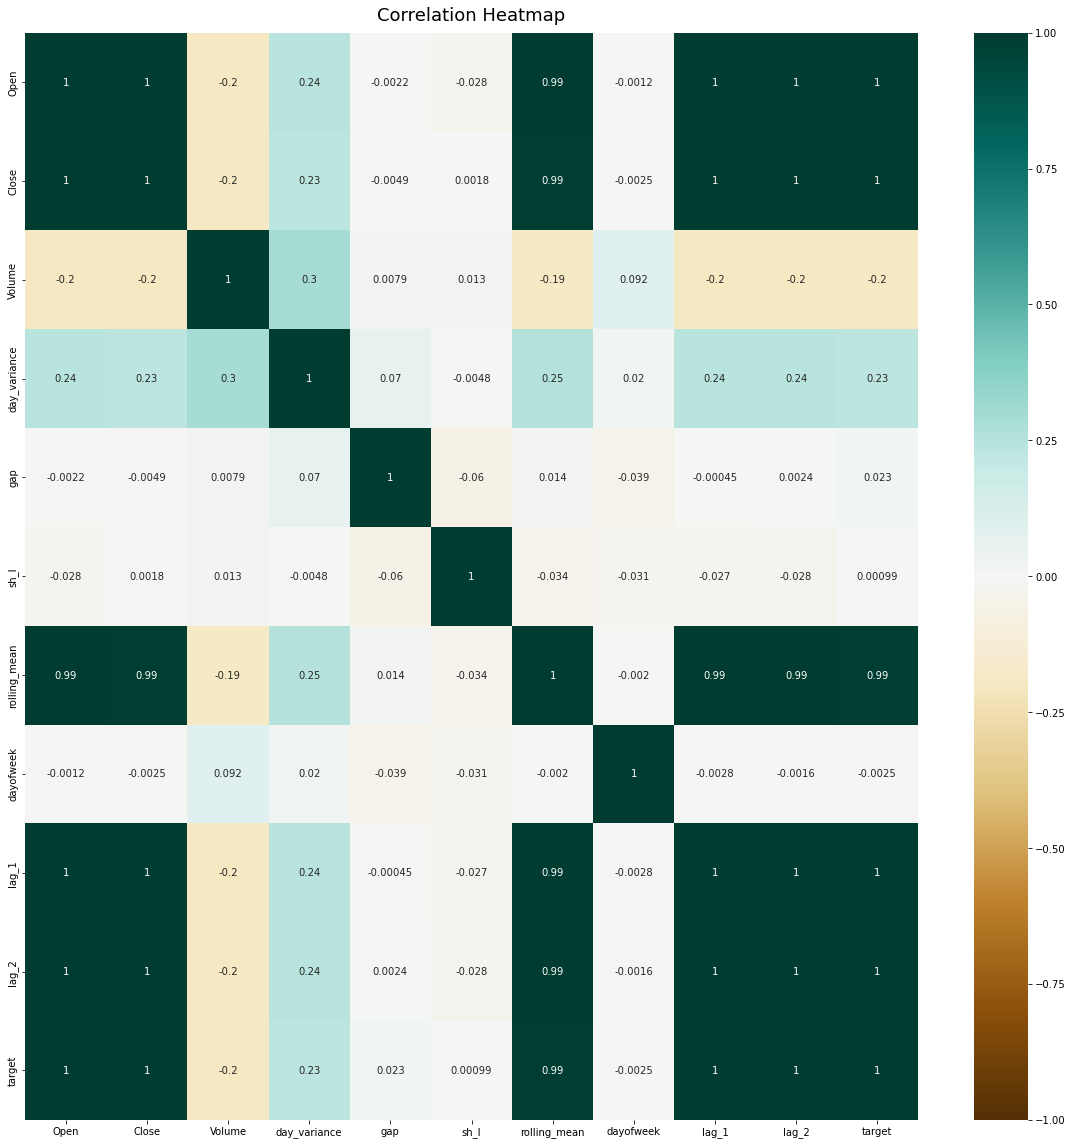

In [42]:
# Built correlation heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(test.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

You can see that yesterday's Opening and Closing prices correlate with the Target, we will remove one of the signs (Opening). It also makes sense to get rid of one of the Lags (lag_1).

In [43]:
test = test.drop(["Open", "lag_1"], axis=1)

In [44]:
test.head()

,Close,Volume,day_variance,gap,sh_l,rolling_mean,dayofweek,lag_2,target
Date,,,,,,,,,
2010-10-05,49.065,14129153,0.745,-0.036,1,48.940870,1,48.534,49.106
2010-10-06,49.106,8961400,0.557,0.131,1,48.976609,2,48.371,49.051
2010-10-07,49.051,28826108,0.314,0.161,0,49.004609,3,49.065,49.907
2010-10-08,49.907,19727129,0.885,0.047,1,49.022522,4,49.106,50.131
2010-10-11,50.131,9203607,0.282,-0.103,1,49.082913,0,49.051,50.037


## 3. Preprocessing and training model

In [45]:
# Let's create a selector class to select the necessary columns for processing
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Данный класс извлекает и возвращает набор данных с теми столбцами,
    имена которых были переданы в качестве аргумента при инициализации
    '''
  
  # Init class
    def __init__(self, feature_names):
        self._feature_names = feature_names 
  
  # Let's put a plug
    def fit(self, X, y = None):
        return self 

  # Data set output
    def transform(self, X, y = None):
        return X[self._feature_names].values 

print('Строка документации: \n', FeatureSelector.__doc__)   

Строка документации: 
 
    Данный класс извлекает и возвращает набор данных с теми столбцами,
    имена которых были переданы в качестве аргумента при инициализации
    


In [46]:
# Create frames with the target variable and attributes:
y = test['target']
X = test.drop(['target'], axis=1)

In [47]:
X.columns

Index(['Close', 'Volume', 'day_variance', 'gap', 'sh_l', 'rolling_mean',
       'dayofweek', 'lag_2'],
      dtype='object')

In [48]:
# Create a categorical feature sheet
cuts = ['sh_l', 'dayofweek']
qty_cuts = len(cuts)
print(qty_cuts, ' Categorical features:', cuts)

# Create a list of quantitative features   
nums = ['Close', 'Volume', 'day_variance', 'gap', 'rolling_mean', 'lag_2']
qty_nums = len(nums)
print(qty_nums, ' Numerical features:', nums)

2  Categorical features: ['sh_l', 'dayofweek']
6  Numerical features: ['Close', 'Volume', 'day_variance', 'gap', 'rolling_mean', 'lag_2']


In [49]:
# We build a pipeline for categorical features
categorical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(cuts)),
                                     ('impute', SimpleImputer(strategy = 'most_frequent')),
                                     ('one_hot_encoder', OrdinalEncoder())]) 

# We build a pipeline for the numeric attributes
numerical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(nums)),
                                   ( 'impute', SimpleImputer(strategy='mean')),
                                    ('std_scaler', StandardScaler())])  

# Merging
all_features=FeatureUnion(transformer_list=[('categorical_pipeline', categorical_pipeline), 
                                            ('numerical_pipeline', numerical_pipeline)]) 

In [50]:
# Let's divide the samples into test and training samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 1123, shuffle=False)

In [51]:
# Running the data through the pipeline
X_train=all_features.fit_transform(X_train)
X_test=all_features.transform(X_test)

In [52]:
# Let's write a function for the RMSE metric
def root_mse(y, y_pred):
    return(mean_squared_error(y, y_pred))**0.5

In [53]:
# Create a metric
rmse=make_scorer(root_mse, greater_is_better=False)

In [54]:
# Let's create a sheet with categorical features
cat_feature=[0,1]

In [55]:
# Find the best LightGBM hyperparameters using GridSearch
params = {
    'num_leaves': list(range(2,20, 2)),
    'max_depth': list(range(2,20, 2)),
    'n_estimators': list(range(1,500, 50))
}

scv = TimeSeriesSplit(n_splits=20)

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0, categorical_feature=cat_feature), params, scoring=rmse, cv=scv)
best_LGBMR=grid.fit(X_train, y_train)

print('Лучшие параметры (CV rmse score =%0.3f):' % best_LGBMR.best_score_)

print("Лучшая модель:\n", best_LGBMR.best_params_)

Лучшие параметры (CV rmse score =-1.314):
Лучшая модель:
 {'max_depth': 14, 'n_estimators': 451, 'num_leaves': 16}


In [56]:
# init best model
best_params={'num_leaves': 16,
             'max_depth': 14,
             'n_estimators': 451}

lgbm_model=lgb.LGBMRegressor(**best_params)

In [57]:
# Trainig model
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], categorical_feature=cat_feature)

[1]	valid_0's l2: 354.868
[2]	valid_0's l2: 300.173
[3]	valid_0's l2: 255.566
[4]	valid_0's l2: 217.387
[5]	valid_0's l2: 186.286
[6]	valid_0's l2: 159.172
[7]	valid_0's l2: 136.67
[8]	valid_0's l2: 117.968
[9]	valid_0's l2: 103.088
[10]	valid_0's l2: 90.6171
[11]	valid_0's l2: 79.5475
[12]	valid_0's l2: 70.8696
[13]	valid_0's l2: 63.2752
[14]	valid_0's l2: 56.5589
[15]	valid_0's l2: 51.1286
[16]	valid_0's l2: 46.6864
[17]	valid_0's l2: 42.925
[18]	valid_0's l2: 39.3245
[19]	valid_0's l2: 36.571
[20]	valid_0's l2: 33.98
[21]	valid_0's l2: 31.9467
[22]	valid_0's l2: 30.1225
[23]	valid_0's l2: 28.3716
[24]	valid_0's l2: 26.8647
[25]	valid_0's l2: 25.5056
[26]	valid_0's l2: 24.4737
[27]	valid_0's l2: 23.4575
[28]	valid_0's l2: 22.6899
[29]	valid_0's l2: 21.8667
[30]	valid_0's l2: 21.2726
[31]	valid_0's l2: 20.6801
[32]	valid_0's l2: 20.1648
[33]	valid_0's l2: 19.6603
[34]	valid_0's l2: 19.2175
[35]	valid_0's l2: 18.8336
[36]	valid_0's l2: 18.4418
[37]	valid_0's l2: 18.1122
[38]	valid_0's 

[333]	valid_0's l2: 17.2807
[334]	valid_0's l2: 17.281
[335]	valid_0's l2: 17.2943
[336]	valid_0's l2: 17.2929
[337]	valid_0's l2: 17.2947
[338]	valid_0's l2: 17.2947
[339]	valid_0's l2: 17.2967
[340]	valid_0's l2: 17.2843
[341]	valid_0's l2: 17.2813
[342]	valid_0's l2: 17.2818
[343]	valid_0's l2: 17.2808
[344]	valid_0's l2: 17.3047
[345]	valid_0's l2: 17.3063
[346]	valid_0's l2: 17.2931
[347]	valid_0's l2: 17.2989
[348]	valid_0's l2: 17.3005
[349]	valid_0's l2: 17.2902
[350]	valid_0's l2: 17.2748
[351]	valid_0's l2: 17.2631
[352]	valid_0's l2: 17.2771
[353]	valid_0's l2: 17.2896
[354]	valid_0's l2: 17.2886
[355]	valid_0's l2: 17.3007
[356]	valid_0's l2: 17.301
[357]	valid_0's l2: 17.3013
[358]	valid_0's l2: 17.2848
[359]	valid_0's l2: 17.2966
[360]	valid_0's l2: 17.2965
[361]	valid_0's l2: 17.2982
[362]	valid_0's l2: 17.2981
[363]	valid_0's l2: 17.2996
[364]	valid_0's l2: 17.299
[365]	valid_0's l2: 17.2955
[366]	valid_0's l2: 17.2989
[367]	valid_0's l2: 17.2942
[368]	valid_0's l2: 17.

LGBMRegressor(max_depth=14, n_estimators=451, num_leaves=16)

In [58]:
y_pred_train=lgbm_model.predict(X_train)

In [59]:
y_pred_test=lgbm_model.predict(X_test)

In [60]:
print('RMSE лучшей модели на тренировочной выборке= %0.3f:' %root_mse(y_train, y_pred_train))
print('RMSE лучшей модели на тестовой выборке= %0.3f:' %root_mse(y_test, y_pred_test))

RMSE лучшей модели на тренировочной выборке= 0.173:
RMSE лучшей модели на тестовой выборке= 4.166:


Text(0, 0.5, 'Цена')

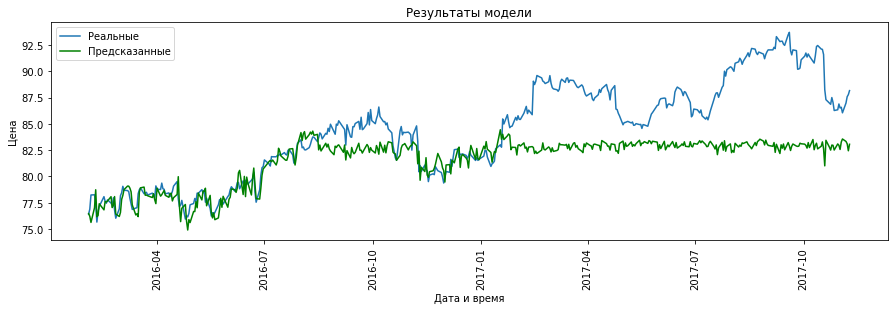

In [61]:
predictions = pd.Series(y_pred_test)
predictions.index = y_test.index

fig2, ax = plt.subplots(figsize=(15, 4))
ax = sns.lineplot(data=y_test, label='Реальные')
sns.lineplot(data=predictions, color='green', label='Предсказанные')
plt.xticks(rotation=90)
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Цена')

# Conclusion:
We trained the model using LGBM. There is too big a difference between the real data and the predicted data. Let's try in another notebook to train the neural network.